## STAT301 2024W2 Group 26 Project 
### Loading of Libraries & Dataset

In [1]:
 Sys.setLanguage("en")   # Remove as necessary for others
suppressPackageStartupMessages({
library(haven)    # Loading of .dta datasets
library(tidyverse)
library(dplyr)
library(datasets)
library(car)
# install.packages("vtable")    # maybe needed if not installed
# install.packages("corrplot")  # maybe needed if not installed
# install.packages("sandwich")  # maybe needed if not installed
# install.packages("lmtest")    # maybe needed if not installed
library(vtable)
library(corrplot)
library(sandwich)
library(lmtest)
library(repr)
library(tidymodels)
# install.packages("stargazer")      # maybe needed if not installed
library(stargazer)
library(purrr)
library(modelr)
library(broom)
library(infer)
library(GGally)
library(coefplot)
})

In [2]:
# Read the CSV file with specified column types 
market_data <- as_factor(read_delim("https://raw.githubusercontent.com/DrakenRaptor/STAT301_ProjectGrp26/refs/heads/main/marketing_campaign.csv", delim = "\t"))

# Check the structure of data types 
str(market_data)

head(market_data)
str(market_data$Dt_Customer)


Rows: 2240 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): Education, Marital_Status, Dt_Customer
dbl (26): ID, Year_Birth, Income, Kidhome, Teenhome, Recency, MntWines, MntF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


spc_tbl_ [2,240 × 29] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ ID                 : num [1:2240] 5524 2174 4141 6182 5324 ...
 $ Year_Birth         : num [1:2240] 1957 1954 1965 1984 1981 ...
 $ Education          : chr [1:2240] "Graduation" "Graduation" "Graduation" "Graduation" ...
 $ Marital_Status     : chr [1:2240] "Single" "Single" "Together" "Together" ...
 $ Income             : num [1:2240] 58138 46344 71613 26646 58293 ...
 $ Kidhome            : num [1:2240] 0 1 0 1 1 0 0 1 1 1 ...
 $ Teenhome           : num [1:2240] 0 1 0 0 0 1 1 0 0 1 ...
 $ Dt_Customer        : chr [1:2240] "04-09-2012" "08-03-2014" "21-08-2013" "10-02-2014" ...
 $ Recency            : num [1:2240] 58 38 26 26 94 16 34 32 19 68 ...
 $ MntWines           : num [1:2240] 635 11 426 11 173 520 235 76 14 28 ...
 $ MntFruits          : num [1:2240] 88 1 49 4 43 42 65 10 0 0 ...
 $ MntMeatProducts    : num [1:2240] 546 6 127 20 118 98 164 56 24 6 ...
 $ MntFishProducts    : num [1:2240] 172 2 111 10 46 0 50 3

ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,⋯,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5524,1957,Graduation,Single,58138,0,0,04-09-2012,58,635,⋯,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344,1,1,08-03-2014,38,11,⋯,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613,0,0,21-08-2013,26,426,⋯,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646,1,0,10-02-2014,26,11,⋯,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293,1,0,19-01-2014,94,173,⋯,5,0,0,0,0,0,0,3,11,0
7446,1967,Master,Together,62513,0,1,09-09-2013,16,520,⋯,6,0,0,0,0,0,0,3,11,0


 chr [1:2240] "04-09-2012" "08-03-2014" "21-08-2013" "10-02-2014" ...


## Introduction & Data Description

The assigned dataset for the project is the Customer Personality Analysis found on In this project, the code below show the descriptive summary of the dataset. There are 2240 observations and 28 variables which captures various attrributes about customers which includes their demographic information, responses to marketing campaigns and purchase history.

### Data Description

This dataset consists of marketing campaign data for a company, with 2,240 observations and 28 variables. The data captures various attributes about customers, including demographic information, purchase history, and responses to marketing campaigns.

| **Variable Name**       | **Type**     | **Description**                                               |
|-------------------------|--------------|---------------------------------------------------------------|
| `ID`                    | Character    | Unique identifier for each customer                           |
| `Year_Birth`            | Numeric      | Year of birth of the customer                                 |
| `Education`             | Character    | Education level of the customer                               |
| `Marital_Status`        | Character    | Marital status of the customer                                |
| `Income`                | Double       | Annual income of the customer                                 |
| `Kidhome`               | Numeric      | Number of children in the customer's household                |
| `Teenhome`              | Numeric      | Number of teenagers in the customer's household               |
| `Dt_Customer`           | Character    | Date of enrollment with the company                           |
| `Recency`               | Numeric      | Days since the last purchase                                  |
| `MntWines`              | Numeric      | Amount spent on wine                                          |
| `MntFruits`             | Numeric      | Amount spent on fruits                                        |
| `MntMeatProducts`       | Numeric      | Amount spent on meat products                                 |
| `MntFishProducts`       | Numeric      | Amount spent on fish products                                 |
| `MntSweetProducts`      | Numeric      | Amount spent on sweet products                                |
| `MntGoldProds`          | Numeric      | Amount spent on gold products                                 |
| `NumDealsPurchases`     | Numeric      | Number of purchases made with a discount                      |
| `NumWebPurchases`       | Numeric      | Number of purchases made through the web                      |
| `NumCatalogPurchases`   | Numeric      | Number of purchases made using a catalog                      |
| `NumStorePurchases`     | Numeric      | Number of purchases made directly in stores                   |
| `NumWebVisitsMonth`     | Numeric      | Number of visits to the company's website in the last month   |
| `AcceptedCmp3`          | Numeric      | 1 if the customer accepted the 3rd campaign, 0 otherwise      |
| `AcceptedCmp4`          | Numeric      | 1 if the customer accepted the 4th campaign, 0 otherwise      |
| `AcceptedCmp5`          | Numeric      | 1 if the customer accepted the 5th campaign, 0 otherwise      |
| `AcceptedCmp1`          | Numeric      | 1 if the customer accepted the 1st campaign, 0 otherwise      |
| `AcceptedCmp2`          | Numeric      | 1 if the customer accepted the 2nd campaign, 0 otherwise      |
| `Response`              | Numeric      | 1 if the customer accepted the last campaign, 0 otherwise     |
| `Complain`              | Numeric      | 1 if the customer has complained in the last 2 years, 0 otherwise |
| `Country`               | Character    | Country of the customer                                       |

**Data Source**: The dataset was collected as part of a marketing campaign analysis. https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data


## Research Question (Question of Interest)

How is customer income related to their spending patterns, specifically the number of web purchases, catalog purchases, store purchases, and website visits, and how do education level and marital status influence these spending behaviors?

**<br> Legend:**


In [3]:
unique(market_data$Education)   # Possible covariates to be used as factor variables for research model
unique(market_data$Marital_Status)     # Possible covariates to be used as factor variables for research model, to classify YOLO as single?

[1] "Graduation" "PhD"        "Master"     "Basic"      "2n Cycle"

[1] "Single"   "Together" "Married"  "Divorced" "Widow"    "Alone"    "Absurd"  
[8] "YOLO"

In [4]:
# Check for 2n Cycle education count, 2n cycle is the same as Master's degree
# TO reclassify them as Master's degree
specific_2n_count <- market_data %>%
  filter(Education == "2n Cycle") |>
  count()

specific_2n_count

# Reclassify 2n Cycle as Master's degree using case_when
market_data <- market_data %>%
    mutate(Education = case_when(
        Education == "2n Cycle" ~ "Master",
        TRUE ~ Education
    ))

unique(market_data$Education)   # Check if 2n Cycle has been reclassified as Master's degree

# Reclassify YOLO, Absurd, Togethe, Alone as single, since it is the same as single
market_data <- market_data %>%
    mutate(Marital_Status = case_when(
        Marital_Status == "YOLO" ~ "Single",
        Marital_Status == "Absurd" ~ "Single",
        Marital_Status == "Together" ~ "Single",
        Marital_Status == "Alone" ~ "Single",
        TRUE ~ Marital_Status
    ))
  
unique(market_data$Marital_Status)   # Check if YOLO, Absurd, Together, Alone has been reclassified as Single


n
<int>
203


[1] "Graduation" "PhD"        "Master"     "Basic"

[1] "Single"   "Married"  "Divorced" "Widow"

In [5]:
# Refactor Marital_Status to numeric values
market_data <- market_data |>
    mutate(Marital_Status = case_when(
        Marital_Status == "Single" ~ 1,
        Marital_Status == "Married" ~ 2,
        Marital_Status == "Divorced" ~ 3,
        Marital_Status == "Widow" ~ 4,
        TRUE ~ NA_real_
    ))

unique(market_data$Marital_Status)   # Check the new numeric values for Marital_Status




[1] 1 2 3 4

In [6]:
market_data <- market_data |>
    mutate(Education = case_when(
        Education == "Basic" ~ 1,
        Education == "High School" ~ 2,
        Education == "Bachelor" ~ 3,
        Education == "Master" ~ 4,
        Education == "PhD" ~ 5,
        TRUE ~ NA_real_
    ))  # |>


unique(market_data$Education)   # Check the new numeric values for Marital_Status

[1] NA  5  4  1

In [7]:
# Filter out NA values in the specified variables
market_data <- market_data |>
    filter(!is.na(Education) & !is.na(Marital_Status) & !is.na(NumWebPurchases) & 
           !is.na(NumCatalogPurchases) & !is.na(NumWebVisitsMonth) & 
           !is.na(NumStorePurchases) & !is.na(Income))

# Check the unique values in the variables to confirm NAs are removed
unique(market_data$Education)
unique(market_data$Marital_Status)
unique(market_data$NumWebPurchases)
unique(market_data$NumCatalogPurchases)
unique(market_data$NumWebVisitsMonth)
unique(market_data$NumStorePurchases)
unique(market_data$Income)

[1] 5 4 1

[1] 2 1 3 4

[1]  5  6  4  3  1  2  7 11  8  9  0 10 23 27

[1]  3  4  0  1  6  2  9  5 10  8  7 22 11 28

[1]  5  6  8  9 20  3  4  2  7  1  0 10 17 19

[1]  6 10  4  2  0  3  5 12  9 13 11  8  7  1

[1]  58293  62513  33454  30351   5648   7500  59354  82800  76995  33812
 [11]  58607  65324  84618  10979  38620  46610  68657  49389  67353  23718
 [21]  48948  20559  72550  79143  82384  55954  75777  67680  88194  66991
 [31]  60631  75251  26326  23559  36138  42394  23626  78497  50150  47823
 [41]  34554  65846  24594  89058  68126  57288  43974  36550  30753  56129
 [51]  32557  19510  71488  54348  77376  61331  41551  62981   9548  33762
 [61]  35860  36921  92859  65104  68352  35688  49605  46344  61010  30523
 [71]  70356  74165 157243  53537  80427  83837  38853  51650  16248  66835
 [81]  30477  28249  32303  45759  24882  66973  36640  69661  46854 102160
 [91]  40637  18890  48721  44377  46014  52195  83790  44551  45204  77622
[101]  30732  79930  34320  81975  62745  22212  23661  79761  60182  31686
[111]  67546  65176  31160  26490  30899  63342  40737  69674  44159  37717
[121]  43776  38179  38097  31788  61905  66313  77882  69867  63841  24480
[131]  65640  44319  50898  35416  32414  55951  35388  42386  57912  58821
[141]  46377  80950  64100  42670  70893  28839  47025  64325  14849  54432
[151]  29999  33996  66334  35178  83532  55212  59292  27190  33181  69759
[161]  60000  68462  65073  46681  62187  52614  35684  29548  38578  46098
[171]  66426  33581  36143  43795  83664  62499  51012  70777  68682  14515
[181]  31395  55521  27213  65808  23616  66465  75865  19789  49505  37401
[191]  18492  82584  93027  10404  84865  67309  50943  51529  32011  56223
[201]  20130  42618  55707  36230  70829  89572  42207  66664  50520  66582
[211]  75261  49269  56937  41644  55842  62010  38961  37760  83151  78825
[221]  28457  78952  58308  55614  59432  78642  67911  48330  24279  64355
[231]  39665  89120  44124  81169  80184  73454  77863  50353  49154  47682
[241]  57954  47352  57247  22944  25315  42710  84169  24683  27159  39548
[251]  60504  81698  54880  15315  71499  62466  48799  52157  29298  38443
[261]  38593  64413  36959  61996  47472  54603  45207  47821  27450  26850
[271]  61794  39684  92163  69882  59973  17459  42169  26224  61467  49618
[281]  21888  30801  26877  45006  18978  48240  35791 162397  30522  54456
[291]  36975  72635  34487  69084  65488  32218  63120  76140  62859  77632
[301]  46463  55282  78710  98777  50616  73059  46734  25965  14661  45068
[311]  21063  29187  54690  59304  59247  81300  36145  65295  41039  66476
[321]  86857 160803  77845  69476  50611  42315  13084  47570  61923  26518
[331]  90247  41335  35682  66375  55250  76618  87305  74806  18988  75012
[341]  56962  35946  53593  45072  70545  17487  64108  34941  48767  38702
[351]  17003  63564  83443  51518  63855  62220  40662  38829  35523  78285
[361]  31626  46891  62058  78939   6835  40760  74250  51124  71466  20425
[371]  17144  42564  43783  62847  82017  45183  70421  60161  61872  82716
[381]  49681  56850  52750  91820  65968  25804  76412  78353  80995  55412
[391]  56575  25130  49494  45889  82504  61618  55284  82347  30843  46374
[401]  38576  85710  44602  38683  49514  57906  43456  19485  70123  42395
[411]  61346  42835  86424  17117  51111  82072  46231  68092  51390  26868
[421]  55260  37087  45921  78420  52278  35641  73113  42607  74637  46015
[431]  39858  34469  24401  74116  68397  79632  64950  25443  32892  67536
[441]  60554  64831  56067  14906  51563  57937  67893  27922  52190  44051
[451]  42767  46106  16927  54237  52597  41021  40233  34596  40706  15716
[461]  59052  80573  82576  46779  33462  65352  82170  79689  35340  24884
[471]  42021  78028  95169  56337  36930  65569  36736  49187  34053  38196
[481]  59412  70924  28440  64504  33564  56320  15038  32173  68316  31056
[491]  37334  46423  37126  33168  33585  77037  28764  69098  25959  27100
[501]  53312  62845  42000  65526  64176  87171  26907  50014  41014  75345
[511]  84460  71691  85844  39190  57236  80910  27590  54210  76045  50870
[521]  65463  54466  16269  33569  36262  22634  3

### EDA and Visualisation

A correlation plot maybe suitable to check for the relationship between the continuous random variable such as `Income`, `NumCatalogPurchases`, `NumWebVisitsMonth`, `NumStorePurchases`, `NumWebPurchases`.

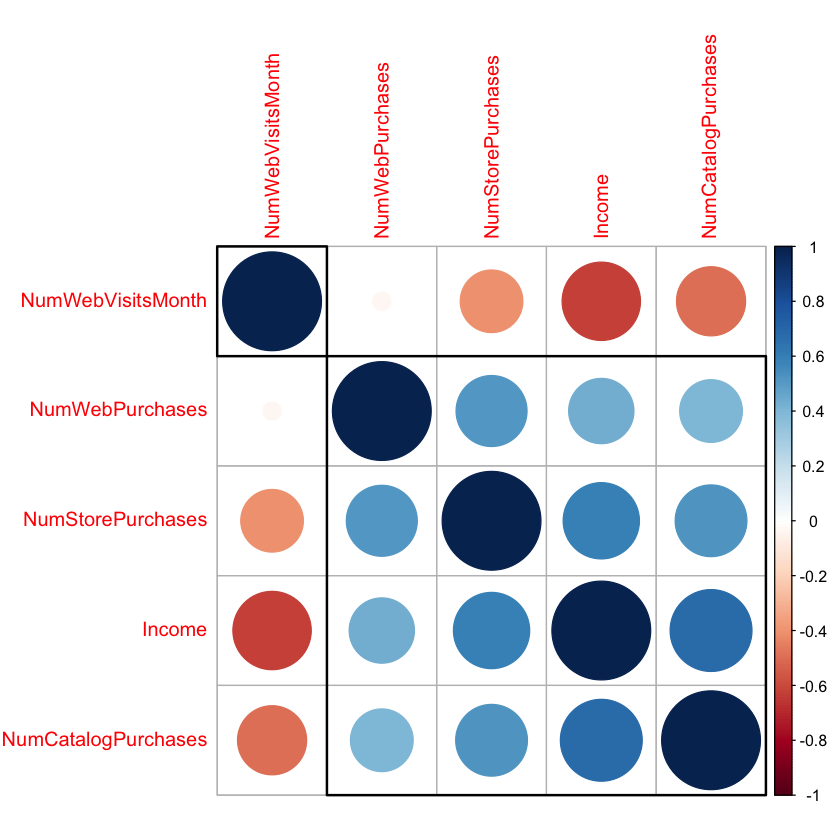

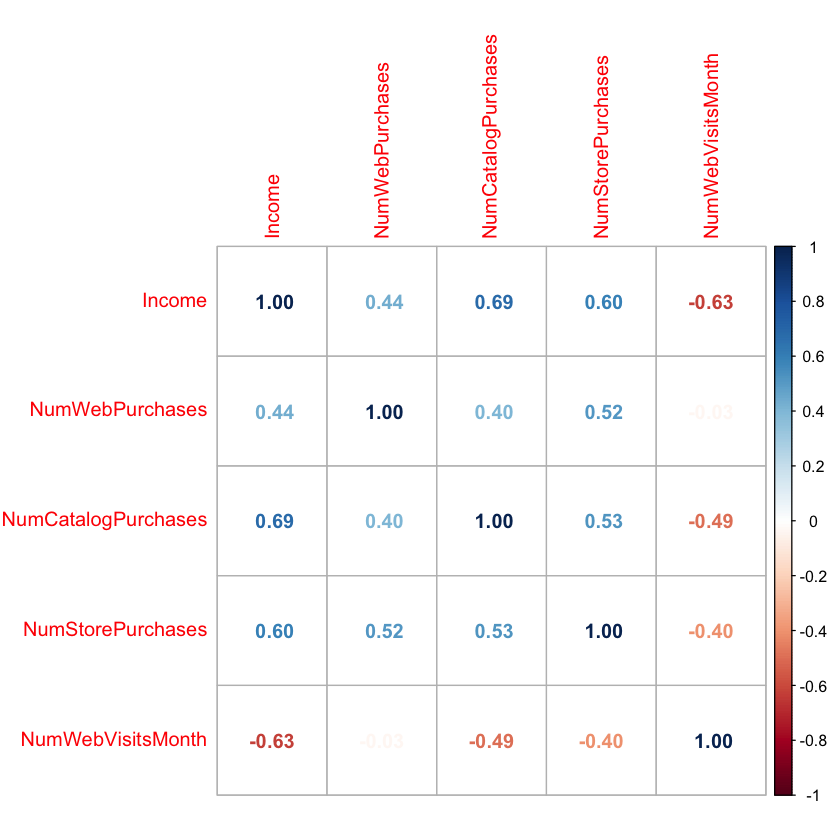

In [8]:
# Using correlation plot to check the relationship between the variables
corr_plt_dat <- market_data[, c("Income", "NumWebPurchases", "NumCatalogPurchases",
 "NumStorePurchases", "NumWebVisitsMonth")] |>
    as.data.frame(corr_plt_dat)

cor_matrix <- cor(corr_plt_dat)

corrplot(cor_matrix, order = "hclust", addrect = 2)
corrplot(cor_matrix, method = "number", addrect = 2)

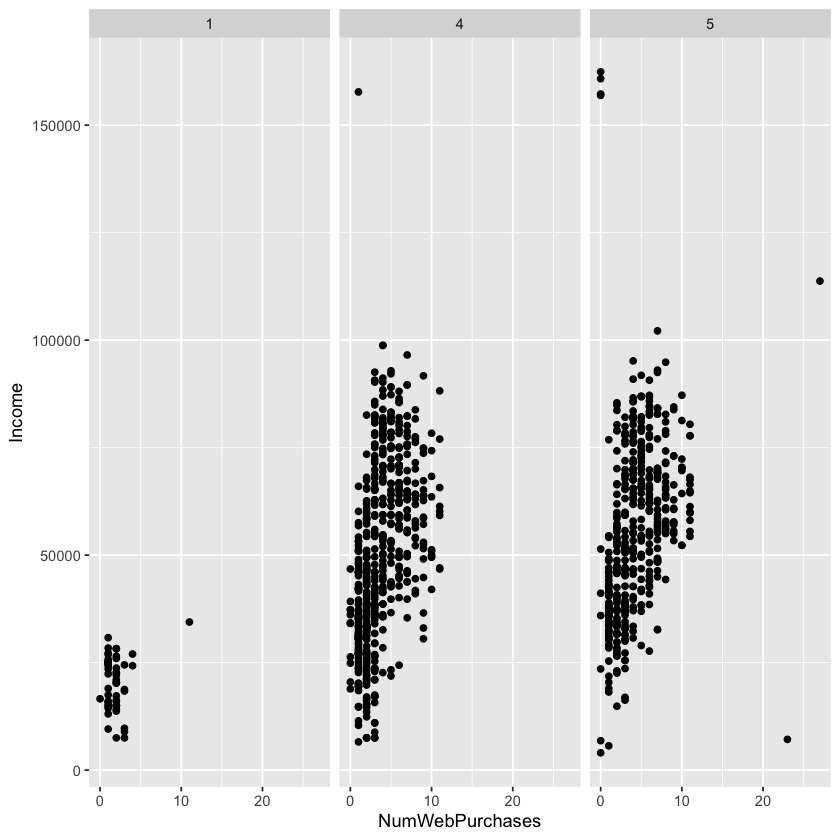

In [9]:
facet_single <- market_data  |>
    ggplot(aes(x = NumWebPurchases, y = Income)) +
    geom_point() +
    facet_wrap(~ Education)

facet_single

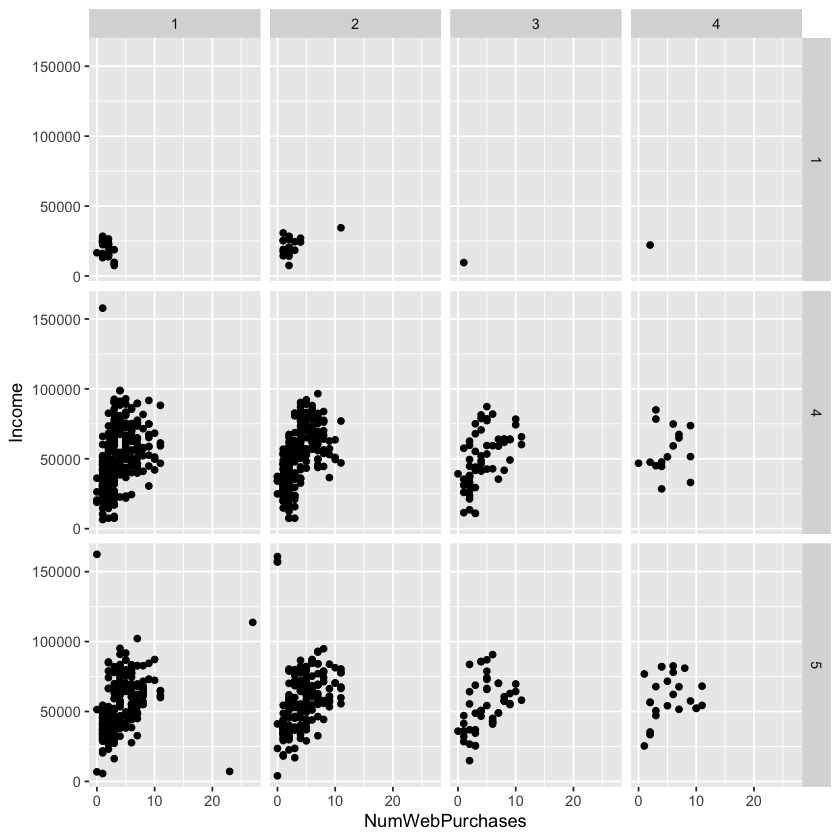

In [10]:
facet_double <- market_data  |>
    ggplot(aes(x = NumWebPurchases, y = Income)) +
    geom_point() +
    facet_grid(Education ~ Marital_Status)

facet_double

`geom_smooth()` using formula = 'y ~ x'


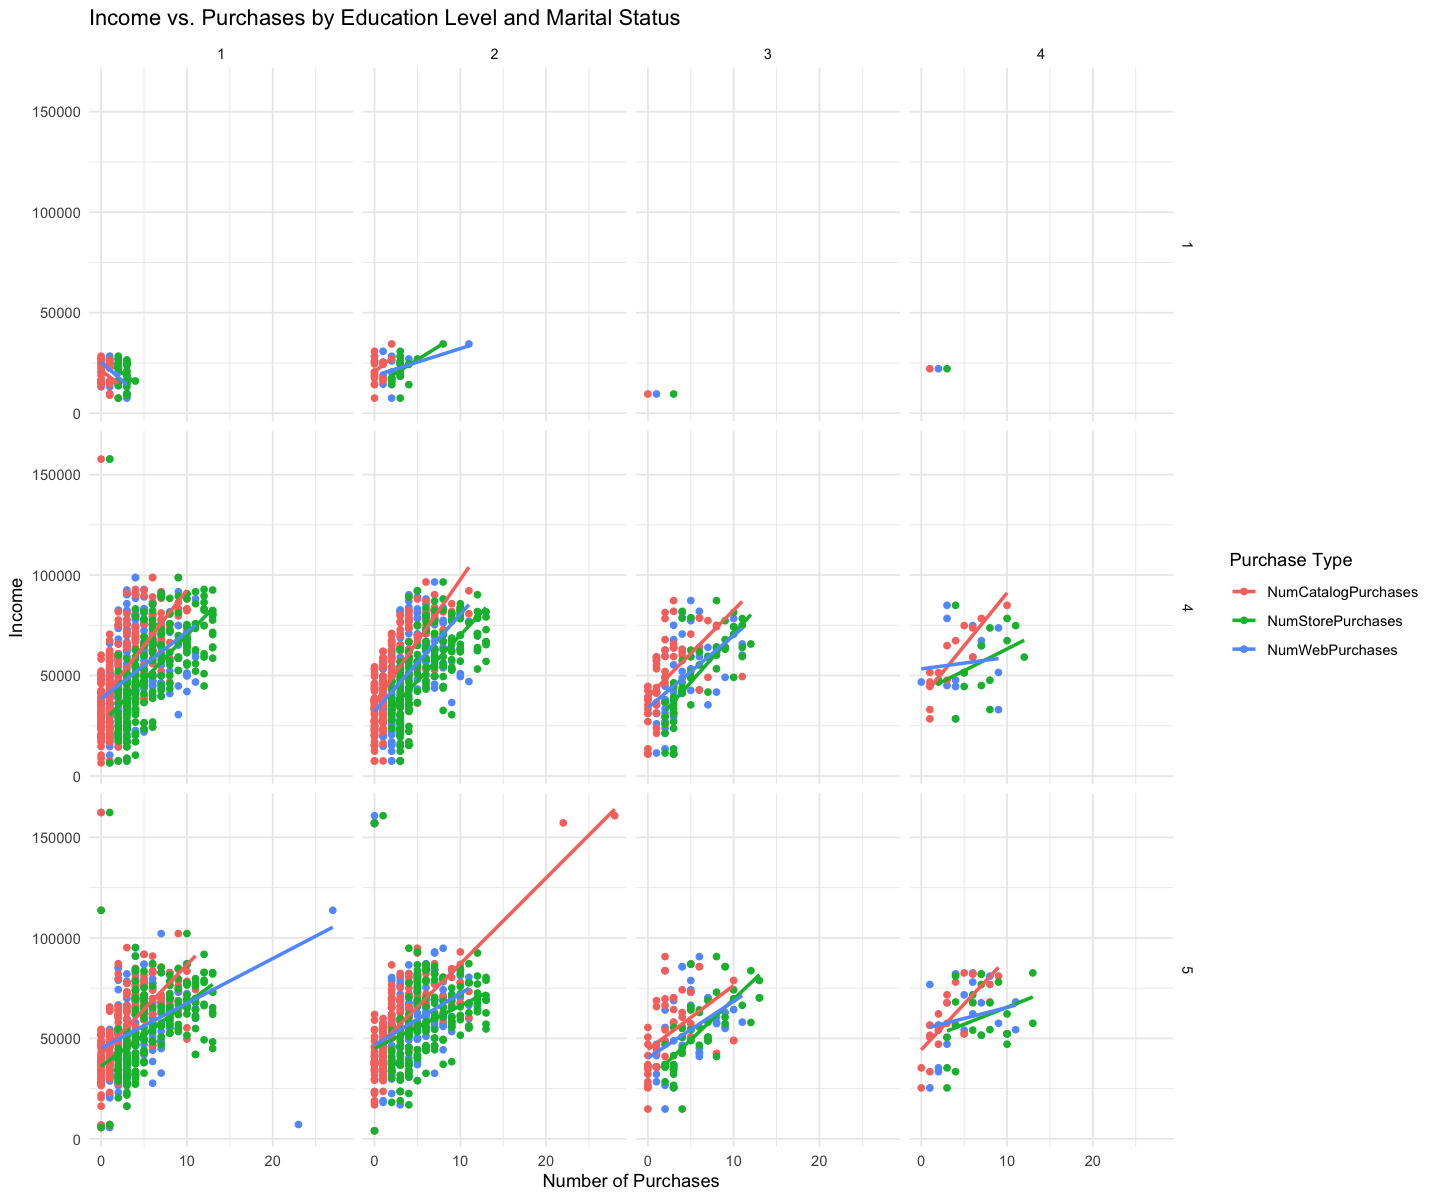

In [11]:
options(repr.plot.width = 12, repr.plot.height = 10)
# Reshape the data to long format for easier plotting
data_long <- market_data |>
  gather(key = "PurchaseType", value = "PurchaseCount",
         NumWebPurchases, NumCatalogPurchases, NumStorePurchases)

# Create the faceted scatter plot with regression lines
ggplot(data_long, aes(x = PurchaseCount, y = Income, color = PurchaseType)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  facet_grid(Education ~ Marital_Status) +
  labs(title = "Income vs. Purchases by Education Level and Marital Status",
       x = "Number of Purchases",
       y = "Income",
       color = "Purchase Type") +
  theme_minimal()  # Aesthetics


In [12]:
data(Mandible)
fm <- lm(length ~ age, data=Mandible, subset=(age <= 28))

## the following commands lead to the same tests:
summary(fm)
coeftest(fm)

## a z test (instead of a t test) can be performed by
coeftest(fm, df = Inf)

if(require(sandwich)) {
## a different covariance matrix can be also used:
## either supplied as a function
coeftest(fm, df = Inf, vcov = vcovHC)
## or as a matrix
coeftest(fm, df = Inf, vcov = vcovHC(fm, type = "HC0"))
}



Call:
lm(formula = length ~ age, data = Mandible, subset = (age <= 
    28))

Residuals:
    Min      1Q  Median      3Q     Max 
-9.2013 -1.6592 -0.1217  1.3420  6.4351 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -11.9534     0.9762  -12.24   <2e-16 ***
age           1.7727     0.0477   37.16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.373 on 156 degrees of freedom
Multiple R-squared:  0.8985,	Adjusted R-squared:  0.8978 
F-statistic:  1381 on 1 and 156 DF,  p-value: < 2.2e-16



t test of coefficients:

              Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -11.953366   0.976227 -12.245 < 2.2e-16 ***
age           1.772730   0.047704  37.161 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



z test of coefficients:

              Estimate Std. Error z value  Pr(>|z|)    
(Intercept) -11.953366   0.976227 -12.245 < 2.2e-16 ***
age           1.772730   0.047704  37.161 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



z test of coefficients:

              Estimate Std. Error z value  Pr(>|z|)    
(Intercept) -11.953366   1.009817 -11.837 < 2.2e-16 ***
age           1.772730   0.054343  32.621 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
